## CEE 6003 Spring 2020 Final Project

## Discovering Utah Water Years With Landsat 5 Imagery 

## Steps

## -Done-
1) Select Image Collection - Landsat 5 (WY1985-WY2011)

2) Choose Index - NDWI (McFeeters) --> (TM2-TM4) / (TM2+TM4) = (Green - NIR) / (Green + NIR)

3) Create Composite Images per Water Year - create a polygon for Utah and use .filterBounds(polygon)

    - This step also involves prior removal of clouds, shadows, and snow using 
    
## -- I am now here --

    - This step will need additional code for water years 1987-2011

4) Clip the composite images to the state of Utah boundaries - ??? use .clip()?

4) Count Positive Values - ??? use .add()?

In [49]:
from datetime import date
today = date.today()
d2 = today.strftime("%B %d, %Y")
print("Updated by Jason Levi Manley, ", d2) #this shows the last time this notebook cell was ran

Updated by Jason Levi Manley,  April 28, 2020


## Purpose
The purpose of this program is to use Landsat 5 imagery in calculating a psuedo-hydrograph for a Utah Water Year (UWY). Because of image constraints (e.g. cloudy pixels, sparse temporal resolution, large study area etc.) a composite image of each water year will be mapped to get water year median values. This will give an overall picture of water availability for each water year in Utah. 

## Method
Water is differentiated from other land surface types because of its unique reflectance properties (see Figure 1). The Normalized Difference Water Index (NDWI) utilizes the Green and NIR bands for surface water detection. The NDWI is defined as:

NDWI = (Green - NIR) / (Green + NIR)

The Green band refers to the Thematic Mapper (TM) Band 2 (0.52-0.60 micrometers) and NIR is the TM Band 4 (0.77-0.90 micrometers)

## Scope
The study area for this project is the state of Utah. The study period is 27 water years or WY1985-WY2011 (WY = 1 OCT - 30 SEP).

### Spectral indices
Spectral indices are based on the fact that reflectance spectra of different land covers are different.  The indices are designed to exploit these differences to accentuate particular land cover types.  Consider the following chart of reflectance spectra for various targets:

In [50]:
#these two lines  below import a picture from the repository and specifies the display size of the picture in the cell

In [51]:
%%html 
<img src='Lab 3 figures/lab 3 fig 1.png', width=900, height=400> 

Figure 1: Observe that the land covers are separable at one or more wavelengths.  Note, in particular, that vegetation curves (green) have relatively high reflectance in the NIR range, where radiant energy is scattered by cell walls ([Bowker et al. 1985](http://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19850022138.pdf)).  Also note that vegetation has low reflectance in the red range, where radiant energy is [absorbed by chlorophyll](https://en.wikipedia.org/wiki/Chlorophyll#/media/File:Chlorophyll_ab_spectra-en.svg).  These observations motivate the formulation of vegetation indices, for example:

## MNDWI (Xu, 2007) {AKA NDSI (Riggs, Hall, Salomonson 1994)}

The Modified Normalized Difference Water Index (adapted from McFeeters 1996) by [Xu in 2007](https://www.tandfonline.com/doi/full/10.1080/01431160600589179?casa_token=kAitHCeJ_ykAAAAA%3AZCMCV0_zJ5nwke4HQnU7-LbMY1dmTAwh-Ivly8dkoR38ho71NYH0R0PQcvYFQdmSZe86bsUD-A)

MNDWI = (Green - MIR) / (Green + MIR)

The Green band refers to the Thematic Mapper (TM) Band 2 (0.52-0.60 micrometers) and MIR is the TM Band 5 (1.55-1.75 micrometers)

This index removes land (natural and built-up) and vegetation noise from the water results. See article for more information.
It also picks up the clouds and snow as water and will not be used for this project.

This index is the same as the NDSI from [Riggs, Hall, and Salomonson (1996)](https://ieeexplore.ieee.org/document/399618). The Landsat 5 NDSI collection is a global composite and will not be used for this project.

## NDWI Gao

The Normalized Difference Water Index from [Gao](https://www.sciencedirect.com/science/article/abs/pii/S0034425796000673) identifies vegetation water content. This different from the NDWI calculation used in this project. For the index used, see NDWI McFeeters below.

As an aside, the Gao paper uses bands that Landsat 5 does not measure...

### NDWI McFeeters
The concept and calculation of the Normalized Difference Water Index (NDWI) for surface water body detection was introduced by [McFeeters](https://www.tandfonline.com/doi/abs/10.1080/01431169608948714) in 1996.

The NDWI calculation:

NDWI = (Green - NIR) / (Green + NIR)

where Green = TM2 = 0.52 - 0.60 micrometers
and NIR = TM4 = 0.77 - 0.90 micrometers 

In this index, positive values should correspond with water pixels. I chose this index because it performs the best/most accurately in visual inspections over NDSI/MNDWI and the Gao NDWI is not applicable.

In [52]:
# Initializing display and earthengine
from IPython.display import Image #I think this imports the base map??
%matplotlib inline

import ee #import Google Earth Engine
ee.Initialize()

# importing ipygee for dynamic mapping
from ipygee import * #imports the ipygee "a set of tools for GEE"
# import geetools for cloud /shadow discrimination
from geetools import ui, cloud_mask

# this function only for Landsat 8 Surface Corrected single image
mask_SR_all = cloud_mask.landsatSR() #this function masks clouds, snow, shadows

# creating a function for masking the entire ImageCollection
def masksr(image):
    cld_free = mask_SR_all(image)
    return cld_free

In [53]:
# # Define a location of interest as a point - if a point is desired
# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent = "levi.manley@aggiemail.usu.edu") #my GEE account 

# address, (latitude, longitude) = geolocator.geocode("Park City, UT") #need to change to a polygon
# print(latitude, longitude) #this will display the latitude and longitude of the point in the bottom of the cell

# point = ee.Geometry.Point([longitude, latitude]) #This gives the coordinates of the geolocated point

In [54]:
#Utah Polygon for Region of Interest (ROI) instead of a point

utPolygon = ee.Geometry.Polygon([
[-111.0522391292252, 41.999611059070254], #East of Bear Lake
[-114.04664347432727, 41.99563035054876], #Northwest corner of UT
[-114.0577421935812, 36.99125567519261], #Southwest corner
    [-112.52858779454836, 37.00054427821885], #Near Kanab (to fix parts of Lake Powell being cut off)
    [-111.57207421050731, 37.000873293638556], #Near Page (dido)
    [-111.12807247908931, 37.0010926392499], #Near East edge of Powell at AZ/UT state line
    [-110.47055763414988, 36.99802170545191], #Where AZ/UT line dips slightly South
[-109.04880647223813, 37.001785083270306], #Four corners
[-109.05088490375093, 41.00239214149569],
[-111.05006538902381, 40.9924421189569]]);

In [55]:
landsat5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR") #this gets the image collection from Google Earth Engine (GEE)

def im_product(img): #this function scales the images ?of the entire image collection?
    img = img.multiply(0.0001)
    return img

#There should be 27 composite images for water years 1985-2011

selected_images1 = landsat5.filterBounds(utPolygon).filterDate('1984-10-01', '1985-09-30') #WY1985
selected_images1 = selected_images1.map(masksr) #this fucntion removes clouds
selected_images1 = selected_images1.map(im_product) 

selected_images2 = landsat5.filterBounds(utPolygon).filterDate('1985-10-01', '1986-09-30') #WY1986
selected_images2 = selected_images2.map(masksr) #this fucntion removes clouds
selected_images2 = selected_images2.map(im_product)

selected_images3 = landsat5.filterBounds(utPolygon).filterDate('1986-10-01', '1987-09-30') #WY1987
selected_images3 = selected_images3.map(masksr) #this fucntion removes clouds
selected_images3 = selected_images3.map(im_product) 

selected_images4 = landsat5.filterBounds(utPolygon).filterDate('1987-10-01', '1988-09-30') #WY1988
selected_images4 = selected_images4.map(masksr) #this fucntion removes clouds
selected_images4 = selected_images4.map(im_product) 

selected_images5 = landsat5.filterBounds(utPolygon).filterDate('1988-10-01', '1989-09-30') #WY1989
selected_images5 = selected_images5.map(masksr) #this fucntion removes clouds
selected_images5 = selected_images5.map(im_product) 

selected_images6 = landsat5.filterBounds(utPolygon).filterDate('1989-10-01', '1990-09-30') #WY1990
selected_images6 = selected_images6.map(masksr) #this fucntion removes clouds
selected_images6 = selected_images6.map(im_product) 

selected_images7 = landsat5.filterBounds(utPolygon).filterDate('1990-10-01', '1991-09-30') #WY1991
selected_images7 = selected_images7.map(masksr) #this fucntion removes clouds
selected_images7 = selected_images7.map(im_product) 

selected_images8 = landsat5.filterBounds(utPolygon).filterDate('1991-10-01', '1992-09-30') #WY1992
selected_images8 = selected_images8.map(masksr) #this fucntion removes clouds
selected_images8 = selected_images8.map(im_product) 

selected_images9 = landsat5.filterBounds(utPolygon).filterDate('1992-10-01', '1993-09-30') #WY1993
selected_images9 = selected_images9.map(masksr) #this fucntion removes clouds
selected_images9 = selected_images9.map(im_product) 

selected_images10 = landsat5.filterBounds(utPolygon).filterDate('1993-10-01', '1994-09-30') #WY1994
selected_images10 = selected_images10.map(masksr) #this fucntion removes clouds
selected_images10 = selected_images10.map(im_product) 

selected_images11 = landsat5.filterBounds(utPolygon).filterDate('1994-10-01', '1995-09-30') #WY1995
selected_images11 = selected_images11.map(masksr) #this fucntion removes clouds
selected_images11 = selected_images11.map(im_product) 

selected_images12 = landsat5.filterBounds(utPolygon).filterDate('1995-10-01', '1996-09-30') #WY1996
selected_images12 = selected_images12.map(masksr) #this fucntion removes clouds
selected_images12 = selected_images12.map(im_product) 

selected_images13 = landsat5.filterBounds(utPolygon).filterDate('1996-10-01', '1997-09-30') #WY1997
selected_images13 = selected_images13.map(masksr) #this fucntion removes clouds
selected_images13 = selected_images13.map(im_product) 

selected_images14 = landsat5.filterBounds(utPolygon).filterDate('1997-10-01', '1998-09-30') #WY1998
selected_images14 = selected_images14.map(masksr) #this fucntion removes clouds
selected_images14 = selected_images14.map(im_product) 

selected_images15 = landsat5.filterBounds(utPolygon).filterDate('1998-10-01', '1999-09-30') #WY1999
selected_images15 = selected_images15.map(masksr) #this fucntion removes clouds
selected_images15 = selected_images15.map(im_product) 

selected_images16 = landsat5.filterBounds(utPolygon).filterDate('1999-10-01', '2000-09-30') #WY2000
selected_images16 = selected_images16.map(masksr) #this fucntion removes clouds
selected_images16 = selected_images16.map(im_product) 

selected_images17 = landsat5.filterBounds(utPolygon).filterDate('2000-10-01', '2001-09-30') #WY2001
selected_images17 = selected_images17.map(masksr) #this fucntion removes clouds
selected_images17 = selected_images17.map(im_product) 

selected_images18 = landsat5.filterBounds(utPolygon).filterDate('2001-10-01', '2002-09-30') #WY2002
selected_images18 = selected_images18.map(masksr) #this fucntion removes clouds
selected_images18 = selected_images18.map(im_product) 

selected_images19 = landsat5.filterBounds(utPolygon).filterDate('2002-10-01', '2003-09-30') #WY2003
selected_images19 = selected_images19.map(masksr) #this fucntion removes clouds
selected_images19 = selected_images19.map(im_product) 

selected_images20 = landsat5.filterBounds(utPolygon).filterDate('2003-10-01', '2004-09-30') #WY2004
selected_images20 = selected_images20.map(masksr) #this fucntion removes clouds
selected_images20 = selected_images20.map(im_product) 

selected_images21 = landsat5.filterBounds(utPolygon).filterDate('2004-10-01', '2005-09-30') #WY2005
selected_images21 = selected_images21.map(masksr) #this fucntion removes clouds
selected_images21 = selected_images21.map(im_product) 

selected_images22 = landsat5.filterBounds(utPolygon).filterDate('2005-10-01', '2006-09-30') #WY2006
selected_images22 = selected_images22.map(masksr) #this fucntion removes clouds
selected_images22 = selected_images22.map(im_product) 

selected_images23 = landsat5.filterBounds(utPolygon).filterDate('2006-10-01', '2007-09-30') #WY2007
selected_images23 = selected_images23.map(masksr) #this fucntion removes clouds
selected_images23 = selected_images23.map(im_product) 

selected_images24 = landsat5.filterBounds(utPolygon).filterDate('2007-10-01', '2008-09-30') #WY2008
selected_images24 = selected_images24.map(masksr) #this fucntion removes clouds
selected_images24 = selected_images24.map(im_product) 

selected_images25 = landsat5.filterBounds(utPolygon).filterDate('2008-10-01', '2009-09-30') #WY2009
selected_images25 = selected_images25.map(masksr) #this fucntion removes clouds
selected_images25 = selected_images25.map(im_product) 

selected_images26 = landsat5.filterBounds(utPolygon).filterDate('2009-10-01', '2010-09-30') #WY2010
selected_images26 = selected_images26.map(masksr) #this fucntion removes clouds
selected_images26 = selected_images26.map(im_product) 

selected_images27 = landsat5.filterBounds(utPolygon).filterDate('2010-10-01', '2011-09-30') #WY2011
selected_images27 = selected_images27.map(masksr) #this fucntion removes clouds
selected_images27 = selected_images27.map(im_product) 

In [56]:
Map = Map() # from ipygee
Map.show() #This opens the map in a window (I think)

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [57]:
# IF YOU USE MEDIAN THEN THE BANDS NAME NEEDS TO BE ADDED "_median". Other options are “mean”, “max”, “min”. 
median_image1 = selected_images1.reduce('median') #WY1985
print(median_image1.bandNames().getInfo()) #self explanatory
median_image2 = selected_images2.reduce('median') #WY1986
median_image3 = selected_images3.reduce('median') #WY1987
median_image4 = selected_images4.reduce('median') #WY1988
median_image5 = selected_images5.reduce('median') #WY1989
median_image6 = selected_images6.reduce('median') #WY1990
median_image7 = selected_images7.reduce('median') #WY1991
median_image8 = selected_images8.reduce('median') #WY1992
median_image9 = selected_images9.reduce('median') #WY1993
median_image10 = selected_images10.reduce('median') #WY1994
median_image11 = selected_images11.reduce('median') #WY1995
median_image12 = selected_images12.reduce('median') #WY1996
median_image13 = selected_images13.reduce('median') #WY1997
median_image14 = selected_images14.reduce('median') #WY1998
median_image15 = selected_images15.reduce('median') #WY1999
median_image16 = selected_images16.reduce('median') #WY2000
median_image17 = selected_images17.reduce('median') #WY2001
median_image18 = selected_images18.reduce('median') #WY2002
median_image19 = selected_images19.reduce('median') #WY2003
median_image20 = selected_images20.reduce('median') #WY2004
median_image21 = selected_images21.reduce('median') #WY2005
median_image22 = selected_images22.reduce('median') #WY2006
median_image23 = selected_images23.reduce('median') #WY2007
median_image24 = selected_images24.reduce('median') #WY2008
median_image25 = selected_images25.reduce('median') #WY2009
median_image26 = selected_images26.reduce('median') #WY2010
median_image27 = selected_images27.reduce('median') #WY2011

['B1_median', 'B2_median', 'B3_median', 'B4_median', 'B5_median', 'B6_median', 'B7_median', 'sr_atmos_opacity_median', 'sr_cloud_qa_median', 'pixel_qa_median', 'radsat_qa_median']


In [58]:
trueColor = {'bands': ['B3_median', 'B2_median', 'B1_median'], 'min': 0, 'max': 0.5} #imagery as our eyes see it

# add layers to map
Map.addLayer(median_image1, trueColor, name = 'Landsat 5 Image WY1985') #this adds an image to the map (WY1985)
Map.addLayer(median_image2, trueColor, name = 'Landsat 5 Image WY1986')
Map.addLayer(utPolygon, {'FF0000'}, 'Utah Polygon') #this adds the Utah polygon to the map (for visualization)

# zoom to the image
bounds = utPolygon #this creates a radius around the point (i think)
Map.centerObject(bounds) #this centers the map

In [59]:
def ndwi_equation(image): #normalized different calculation function for entire image (I think)
    ndwi_im = image.normalizedDifference(['B2', 'B4']) #this performs the normalized difference calculation based on order of inputs
    return ndwi_im
    
ndwi1 = selected_images1.map(ndwi_equation)   
ndwi_median1 = ndwi1.reduce('median')
ndwi_median1_utClip = ndwi_median1.clip(utPolygon)  #this should clip the WY1985 image

ndwi2 = selected_images2.map(ndwi_equation)
ndwi_median2 = ndwi2.reduce('median')
ndwi_median2_utClip = ndwi_median2.clip(utPolygon)  #this should clip the WY1986 image

ndwi3 = selected_images3.map(ndwi_equation)   
ndwi_median3 = ndwi3.reduce('median')
ndwi_median3_utClip = ndwi_median3.clip(utPolygon)

ndwi4 = selected_images4.map(ndwi_equation)   
ndwi_median4 = ndwi4.reduce('median')
ndwi_median4_utClip = ndwi_median4.clip(utPolygon)

ndwi5 = selected_images5.map(ndwi_equation)   
ndwi_median5 = ndwi5.reduce('median')
ndwi_median5_utClip = ndwi_median5.clip(utPolygon)

ndwi6 = selected_images6.map(ndwi_equation)   
ndwi_median6 = ndwi6.reduce('median')
ndwi_median6_utClip = ndwi_median6.clip(utPolygon)

ndwi7 = selected_images7.map(ndwi_equation)   
ndwi_median7 = ndwi7.reduce('median')
ndwi_median7_utClip = ndwi_median7.clip(utPolygon)

ndwi8 = selected_images8.map(ndwi_equation)   
ndwi_median8 = ndwi8.reduce('median')
ndwi_median8_utClip = ndwi_median8.clip(utPolygon)

ndwi9 = selected_images9.map(ndwi_equation)   
ndwi_median9 = ndwi9.reduce('median')
ndwi_median9_utClip = ndwi_median9.clip(utPolygon)

ndwi10 = selected_images10.map(ndwi_equation)   
ndwi_median10 = ndwi10.reduce('median')
ndwi_median10_utClip = ndwi_median10.clip(utPolygon)

ndwi11 = selected_images11.map(ndwi_equation)   
ndwi_median11 = ndwi11.reduce('median')
ndwi_median11_utClip = ndwi_median11.clip(utPolygon)

ndwi12 = selected_images12.map(ndwi_equation)   
ndwi_median12 = ndwi12.reduce('median')
ndwi_median12_utClip = ndwi_median12.clip(utPolygon)

ndwi13 = selected_images13.map(ndwi_equation)   
ndwi_median13 = ndwi13.reduce('median')
ndwi_median13_utClip = ndwi_median13.clip(utPolygon)

ndwi14 = selected_images14.map(ndwi_equation)   
ndwi_median14 = ndwi14.reduce('median')
ndwi_median14_utClip = ndwi_median14.clip(utPolygon)

ndwi15 = selected_images15.map(ndwi_equation)   
ndwi_median15 = ndwi15.reduce('median')
ndwi_median15_utClip = ndwi_median15.clip(utPolygon)

ndwi16 = selected_images16.map(ndwi_equation)   
ndwi_median16 = ndwi16.reduce('median')
ndwi_median16_utClip = ndwi_median16.clip(utPolygon)

ndwi17 = selected_images17.map(ndwi_equation)   
ndwi_median17 = ndwi17.reduce('median')
ndwi_median17_utClip = ndwi_median17.clip(utPolygon)

ndwi18 = selected_images18.map(ndwi_equation)   
ndwi_median18 = ndwi18.reduce('median')
ndwi_median18_utClip = ndwi_median18.clip(utPolygon)

ndwi19 = selected_images19.map(ndwi_equation)   
ndwi_median19 = ndwi19.reduce('median')
ndwi_median19_utClip = ndwi_median19.clip(utPolygon)

ndwi20 = selected_images20.map(ndwi_equation)   
ndwi_median20 = ndwi20.reduce('median')
ndwi_median20_utClip = ndwi_median20.clip(utPolygon)

ndwi21 = selected_images21.map(ndwi_equation)   
ndwi_median21 = ndwi21.reduce('median')
ndwi_median21_utClip = ndwi_median21.clip(utPolygon)

ndwi22 = selected_images22.map(ndwi_equation)   
ndwi_median22 = ndwi22.reduce('median')
ndwi_median22_utClip = ndwi_median22.clip(utPolygon)

ndwi23 = selected_images23.map(ndwi_equation)   
ndwi_median23 = ndwi23.reduce('median')
ndwi_median23_utClip = ndwi_median23.clip(utPolygon)

ndwi24 = selected_images24.map(ndwi_equation)   
ndwi_median24 = ndwi24.reduce('median')
ndwi_median24_utClip = ndwi_median24.clip(utPolygon)

ndwi25 = selected_images25.map(ndwi_equation)   
ndwi_median25 = ndwi25.reduce('median')
ndwi_median25_utClip = ndwi_median25.clip(utPolygon)

ndwi26 = selected_images26.map(ndwi_equation)   
ndwi_median26 = ndwi26.reduce('median')
ndwi_median26_utClip = ndwi_median26.clip(utPolygon)

ndwi27 = selected_images27.map(ndwi_equation)   
ndwi_median27 = ndwi27.reduce('median')
ndwi_median27_utClip = ndwi_median27.clip(utPolygon)

Display the NDWI image with a color palette:

?How to get black and white or something with good contrast for colorblind folks? done

In [60]:
#In this cell the NDWI layers of interest are mapped

#vegPalette = ['#0048FB','#FFFFFF','#CE7E45','#FAD163','#74A909','#3A7405','#1A3B03'] #colors (which is inadequate for color blind people)
# vegPalette = ['white','yellow', 'green','blue'] #this makes sense
watPalette = ['00FFFF', '0000FF']
Map.addLayer(ndwi_median1, {min: -0.0, max: 1, 'palette': watPalette},name = 'NDWI WY1985') #how do I know the best min and max? 
#The index for water detection is essentially 0-1). Clouds are being classified as water :( is there a function to correct this? done
Map.addLayer(ndwi_median2, {min: -0.0, max: 1, 'palette': watPalette},name = 'NDWI WY1986')

Map.addLayer(ndwi_median1_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY1985 Clip')
Map.addLayer(ndwi_median2_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY1986 Clip')
Map.addLayer(ndwi_median3_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY1987 Clip')
Map.addLayer(ndwi_median4_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY1988 Clip')
Map.addLayer(ndwi_median5_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY1989 Clip')
Map.addLayer(ndwi_median6_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY1990 Clip')
Map.addLayer(ndwi_median7_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY1991 Clip')
Map.addLayer(ndwi_median8_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY1992 Clip')
Map.addLayer(ndwi_median9_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY1993 Clip')
Map.addLayer(ndwi_median10_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY1994 Clip')
Map.addLayer(ndwi_median11_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY1995 Clip')
Map.addLayer(ndwi_median12_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY1996 Clip')
Map.addLayer(ndwi_median13_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY1997 Clip')
Map.addLayer(ndwi_median14_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY1998 Clip')
Map.addLayer(ndwi_median15_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY1999 Clip')
Map.addLayer(ndwi_median16_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY2000 Clip')
Map.addLayer(ndwi_median17_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY2001 Clip')
Map.addLayer(ndwi_median18_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY2002 Clip')
Map.addLayer(ndwi_median19_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY2003 Clip')
Map.addLayer(ndwi_median20_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY2004 Clip')
Map.addLayer(ndwi_median21_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY2005 Clip')
Map.addLayer(ndwi_median22_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY2006 Clip')
Map.addLayer(ndwi_median23_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY2007 Clip')
Map.addLayer(ndwi_median24_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY2008 Clip')
Map.addLayer(ndwi_median25_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY2009 Clip')
Map.addLayer(ndwi_median26_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY2010 Clip')
Map.addLayer(ndwi_median27_utClip, {min: 0.000001, max: 1, 'palette': watPalette},name = 'NDWI WY2011 Clip')

In [61]:
#In the cells below the NDWI is summed per water year

# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im1 = ndwi_median1_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary1 = binary_im1.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info1 = meanDictionary1.getInfo()

import pandas as pd
df1 = pd.DataFrame(list(value_info1.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage1 = (df1.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY1985:', acreage1, '(km^2)') #area of pixels in sq kilometers
#.gt
# Area of water pixels

Area of water pixels WY1985: 106.64940352941176 (km^2)


In [62]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im2 = ndwi_median2_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary2 = binary_im2.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info2 = meanDictionary2.getInfo()

df2 = pd.DataFrame(list(value_info2.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage2 = (df2.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY1986:', acreage2, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY1986: 111.57364588235293 (km^2)


In [63]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im3 = ndwi_median3_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary3 = binary_im3.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info3 = meanDictionary3.getInfo()

df3 = pd.DataFrame(list(value_info3.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage3 = (df3.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY1987:', acreage3, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY1987: 115.17442941176469 (km^2)


In [64]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im4 = ndwi_median4_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary4 = binary_im4.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info4 = meanDictionary4.getInfo()

df4 = pd.DataFrame(list(value_info4.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage4 = (df4.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY1988:', acreage4, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY1988: 124.45827176470588 (km^2)


In [65]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im5 = ndwi_median5_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary5 = binary_im5.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info5 = meanDictionary5.getInfo()

df5 = pd.DataFrame(list(value_info5.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage5 = (df5.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY1989:', acreage5, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY1989: 119.99888470588235 (km^2)


In [66]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im6 = ndwi_median6_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary6 = binary_im6.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info6 = meanDictionary6.getInfo()

df6 = pd.DataFrame(list(value_info6.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage6 = (df6.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY1990:', acreage6, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY1990: 107.03426823529409 (km^2)


In [67]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im7 = ndwi_median7_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary7 = binary_im7.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info7 = meanDictionary7.getInfo()

df7 = pd.DataFrame(list(value_info7.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage7 = (df7.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY1991:', acreage7, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY1991: 93.86861647058824 (km^2)


In [68]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im8 = ndwi_median8_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary8 = binary_im8.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info8 = meanDictionary8.getInfo()

df8 = pd.DataFrame(list(value_info8.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage8 = (df8.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY1992:', acreage8, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY1992: 88.16700352941176 (km^2)


In [69]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im9 = ndwi_median9_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary9 = binary_im9.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info9 = meanDictionary9.getInfo()

df9 = pd.DataFrame(list(value_info9.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage9 = (df9.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY1993:', acreage9, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY1993: 98.54985176470588 (km^2)


In [70]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im10 = ndwi_median10_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary10 = binary_im10.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info10 = meanDictionary10.getInfo()

df10 = pd.DataFrame(list(value_info10.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage10 = (df10.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY1994:', acreage10, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY1994: 88.2807388235294 (km^2)


In [71]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im11 = ndwi_median11_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary11 = binary_im11.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info11 = meanDictionary11.getInfo()

df11 = pd.DataFrame(list(value_info11.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage11 = (df11.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY1995:', acreage11, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY1995: 91.89300705882353 (km^2)


In [72]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im12 = ndwi_median12_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary12 = binary_im12.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info12 = meanDictionary12.getInfo()

df12 = pd.DataFrame(list(value_info12.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage12 = (df12.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY1996:', acreage12, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY1996: 93.05029058823528 (km^2)


In [73]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im13 = ndwi_median13_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary13 = binary_im13.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info13 = meanDictionary13.getInfo()

df13 = pd.DataFrame(list(value_info13.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage13 = (df13.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY1997:', acreage13, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY1997: 94.76119058823528 (km^2)


In [74]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im14 = ndwi_median14_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary14 = binary_im14.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info14 = meanDictionary14.getInfo()

df14 = pd.DataFrame(list(value_info14.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage14 = (df14.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY1998:', acreage14, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY1998: 102.39049058823527 (km^2)


In [75]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im15 = ndwi_median15_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary15 = binary_im15.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info15 = meanDictionary15.getInfo()

df15 = pd.DataFrame(list(value_info15.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage15 = (df15.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY1999:', acreage15, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY1999: 108.10841647058821 (km^2)


In [76]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im16 = ndwi_median16_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary16 = binary_im16.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info16 = meanDictionary16.getInfo()

df16 = pd.DataFrame(list(value_info16.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage16 = (df16.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY2000:', acreage16, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY2000: 101.00753294117646 (km^2)


In [77]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im17 = ndwi_median17_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary17 = binary_im17.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info17 = meanDictionary17.getInfo()

df17 = pd.DataFrame(list(value_info17.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage17 = (df17.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY2001:', acreage17, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY2001: 96.67357058823528 (km^2)


In [78]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im18 = ndwi_median18_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary18 = binary_im18.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info18 = meanDictionary18.getInfo()

df18 = pd.DataFrame(list(value_info18.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage18 = (df18.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY2002:', acreage18, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY2002: 85.36305529411764 (km^2)


In [79]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im19 = ndwi_median19_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary19 = binary_im19.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info19 = meanDictionary19.getInfo()

df19 = pd.DataFrame(list(value_info19.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage19 = (df19.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY2003:', acreage19, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY2003: 77.24618117647057 (km^2)


In [80]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im20 = ndwi_median20_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary20 = binary_im20.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info20 = meanDictionary20.getInfo()

df20 = pd.DataFrame(list(value_info20.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage20 = (df20.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY2004:', acreage20, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY2004: 76.72619647058823 (km^2)


In [81]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im21 = ndwi_median21_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary21 = binary_im21.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info21 = meanDictionary21.getInfo()

df21 = pd.DataFrame(list(value_info21.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage21 = (df21.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY2005:', acreage21, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY2005: 87.55702235294116 (km^2)


In [82]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im22 = ndwi_median22_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary22 = binary_im22.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info22 = meanDictionary22.getInfo()

df22 = pd.DataFrame(list(value_info22.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage22 = (df22.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY2006:', acreage22, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY2006: 82.4396294117647 (km^2)


In [83]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im23 = ndwi_median23_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary23 = binary_im23.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info23 = meanDictionary23.getInfo()

df23 = pd.DataFrame(list(value_info23.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage23 = (df23.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY2007:', acreage23, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY2007: 79.878 (km^2)


In [84]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im24 = ndwi_median24_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary24 = binary_im24.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info24 = meanDictionary24.getInfo()

df24 = pd.DataFrame(list(value_info24.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage24 = (df24.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY2008:', acreage24, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY2008: 75.6175094117647 (km^2)


In [85]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im25 = ndwi_median25_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary25 = binary_im25.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info25 = meanDictionary25.getInfo()

df25 = pd.DataFrame(list(value_info25.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage25 = (df25.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY2009:', acreage25, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY2009: 76.11679058823529 (km^2)


In [86]:
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im26 = ndwi_median26_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary26 = binary_im26.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info26 = meanDictionary26.getInfo()

df26 = pd.DataFrame(list(value_info26.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage26 = (df26.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY2010:', acreage26, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY2010: 68.98327764705881 (km^2)


In [87]:
#In this cell the NDWI is summed per water year
# THIS CODE CREATES A BINARY IMAGE OF YOUR INDEX, POSITIVE VALUES ARE 1 NEGATIVE VALUES 0
binary_im = ndwi_median27_utClip.gt(0)
# Map.addLayer(binary_im)

# // Reduce the region. The region parameter is the Feature geometry. THIS IS THE CODE FOR ADDING THE BINARY IMAGE
meanDictionary27 = binary_im.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = utPolygon,
  scale = 300,
  maxPixels = 1e9
)

value_info27 = meanDictionary27.getInfo()

df27 = pd.DataFrame(list(value_info27.items()),columns=['Band','pixels'])
# extracting the number of pixels from the valueinfo27
acreage27 = (df27.iloc[0]['pixels']) * 30 * 30 * 0.000001
print('Area of water pixels WY2011:', acreage27, '(km^2)') #area of pixels in sq kilometers

Area of water pixels WY2011: 84.71550352941176 (km^2)


In [88]:
#Array of area results in this cell

wyResults = [acreage1, acreage2, acreage3, acreage4, acreage5, acreage6, acreage7, acreage8, acreage9, acreage10,
             acreage11, acreage12, acreage13, acreage14, acreage15, acreage16, acreage17, acreage18, acreage19, acreage20,
             acreage21, acreage22, acreage23, acreage24, acreage25, acreage26, acreage27];

print(wyResults)

[106.64940352941176, 111.57364588235293, 115.17442941176469, 124.45827176470588, 119.99888470588235, 107.03426823529409, 93.86861647058824, 88.16700352941176, 98.54985176470588, 88.2807388235294, 91.89300705882353, 93.05029058823528, 94.76119058823528, 102.39049058823527, 108.10841647058821, 101.00753294117646, 96.67357058823528, 85.36305529411764, 77.24618117647057, 76.72619647058823, 87.55702235294116, 82.4396294117647, 79.878, 75.6175094117647, 76.11679058823529, 68.98327764705881, 84.71550352941176]


In [89]:
#create a list of water years
wys = list(range(1985, 2012, 1))
print(len(wys))

27


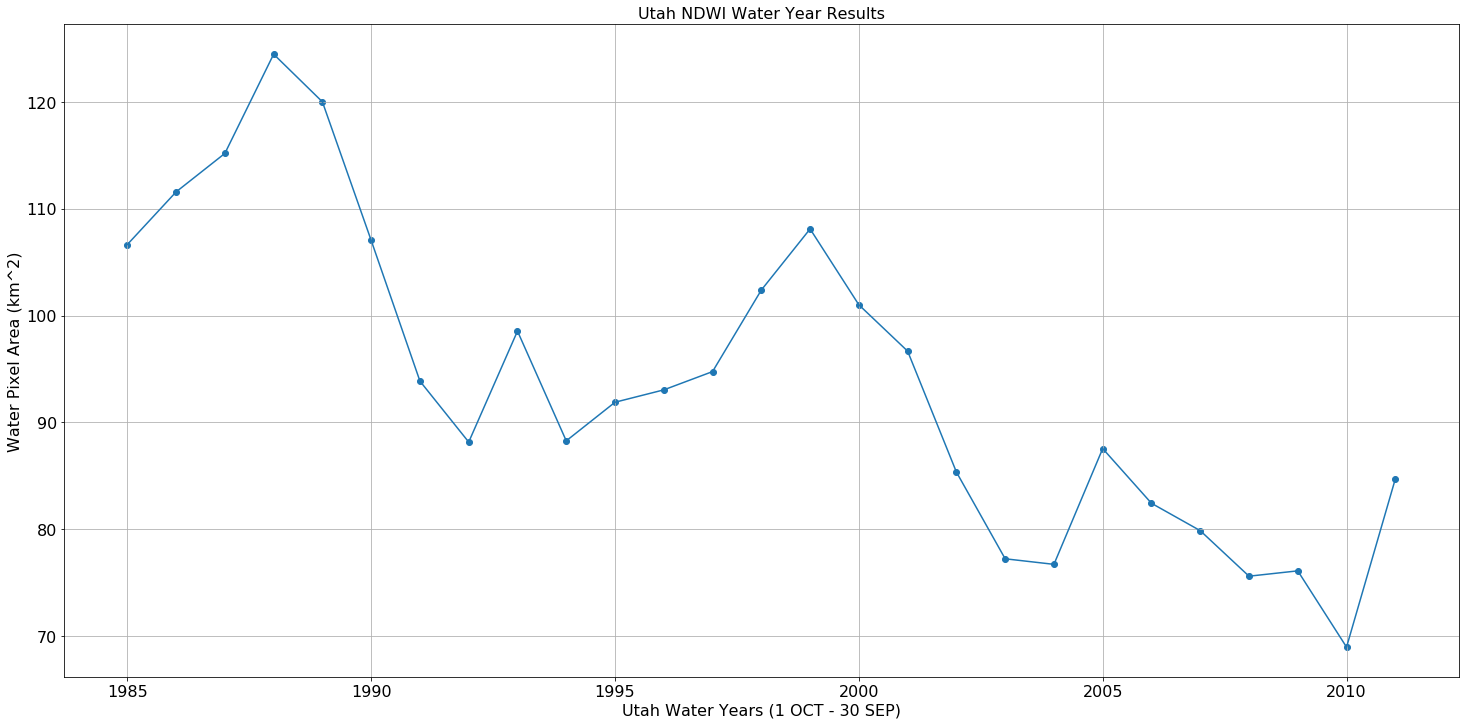

In [92]:
#plot the water years and acreage results

import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
BIGGEST_SIZE = 24

plt.rc('font', size=BIGGEST_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.figure(figsize=(25,12))
plt.scatter(wys, wyResults)
plt.plot(wys, wyResults)
plt.grid()
plt.title('Utah NDWI Water Year Results')
plt.xlabel('Utah Water Years (1 OCT - 30 SEP)')
plt.ylabel('Water Pixel Area (km^2)')
plt.show()

In [91]:
#I am unable to implement video code... for now

utClipVid = [ndwi_median1_utClip, ndwi_median2_utClip, ndwi_median3_utClip, ndwi_median4_utClip, ndwi_median5_utClip, 
             ndwi_median6_utClip, ndwi_median7_utClip, ndwi_median8_utClip, ndwi_median9_utClip, ndwi_median10_utClip,
             ndwi_median11_utClip, ndwi_median12_utClip, ndwi_median13_utClip, ndwi_median14_utClip, ndwi_median15_utClip, 
             ndwi_median16_utClip, ndwi_median17_utClip, ndwi_median18_utClip, ndwi_median19_utClip, ndwi_median20_utClip,
             ndwi_median21_utClip, ndwi_median22_utClip, ndwi_median23_utClip, ndwi_median24_utClip, ndwi_median25_utClip, 
             ndwi_median26_utClip, ndwi_median27_utClip]


## Select bands
#bands = clouds.select(['B4', 'B3', 'B2'])

## Make 8 bit data
def convertBit(image):
    return image.multiply(512).uint8()  

## Convert bands to output video  
outputVideo = utClipVid.map(convertBit)

print("Starting to create a video")

## Export video to Google Drive
out = batch.Export.video.toDrive(outputVideo, description = 'Utah NDWI WY1985-WY2011', dimensions = 720, framesPerSecond = 1, 
                                 region = ([5.588144,51.993435], [5.727906, 51.993435],[5.727906, 51.944356],[5.588144, 51.944356]), 
                                 maxFrames = 10000)

## Process the image
process = batch.Task.start(out)

print("Process sent to cloud")

AttributeError: 'list' object has no attribute 'map'

## This cell is notes for me to remember...
landsat4 = ee.ImageCollection("LANDSAT/LT04/C01/T1_SR") #this gets the image collection from Google Earth Engine (GEE)
#I need to clip out the entire state of Utah if possible. Maybe we could assign more cpu's?
#I also need to create a time series of images with MNDWI calculations performed
#How to correct for clouds? I see methods for masking clouds but this masks the entire pixel I think...
image = ee.Image(landsat4 #this defines one image
    .filterBounds(utPolygon) #this gets only images that overlap this point
    .filterDate('1982-10-01', '1993-09-30') #self explanatory
    .sort('CLOUD_COVER_LAND') #the image that first pops up has clouds that interfere 
                 # with Bear Lake (a major player in Utah surface water / Bear River watershed) Is there a correction function?
    .first()) #This gets the first image in sorted order [so should be the least cloudy, right?]

image = image.multiply(0.0001) #Why don't we multiply by 10,000?

trueColor = {'bands': ['B3', 'B2', 'B1'], 'min': 0, 'max': 0.5} #my "trueColor" is turning out red. Is this an array?

print(image.bandNames().getInfo()) #self explanatory